In [1]:
import matplotlib.pyplot as plt
from basic_stimuli import generate_stimuli, generate_center_black_grating
import torch
from modeling.models.bethge import BethgeModel
import numpy as np
from tqdm import tqdm
from analysis.Stat_utils import get_site_corr
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from surround_supression_utils import *
import os
#net.load_state_dict(torch.load('../saved_models/cropped_models/'+site+'_size_'+str(size)+'_model'))

In [33]:
corr = get_site_corr(net,device,site)
print(np.mean(corr))

100%|██████████| 324/324 [00:00<00:00, 1779.46it/s]

0.6335310693674946


In [2]:
sites = ['m1s1', 'm1s2', 'm1s3', 'm2s1', 'm2s2', 'm3s1']
all_site_response_data = []

for site_idx, site in enumerate(sites):
    val_y = np.load('../data/Processed_Tang_data/all_sites_data_prepared/New_response_data/valRsp_' + site + '.npy')
    channels = 256
    num_layers = 9
    input_size = 50
    output_size = val_y.shape[1]
    first_k = 9
    later_k = 3
    pool_size = 2
    factorized = True

    num_maps = 1

    net = BethgeModel(channels=channels, num_layers=num_layers, input_size=input_size,
                      output_size=output_size, first_k=first_k, later_k=later_k,
                      input_channels=1, pool_size=pool_size, factorized=True,
                      num_maps=num_maps).cuda()

    net.load_state_dict(torch.load('../saved_models/new_learned_models/' + site + '_9_model_version_0'))
    net.eval()
    response_data = get_surround_only_response(net)
    response_center = get_diff_freq_response(net)
    all_site_response_data.append([response_data, response_center])
    print(response_data.shape, response_center.shape)

100%|██████████| 302/302 [06:21<00:00,  1.26s/it]


(302, 25) (302, 5, 25)


100%|██████████| 330/330 [07:13<00:00,  1.31s/it]


(330, 25) (330, 5, 25)


100%|██████████| 175/175 [03:35<00:00,  1.23s/it]


(175, 25) (175, 5, 25)


100%|██████████| 299/299 [06:25<00:00,  1.29s/it]


(299, 25) (299, 5, 25)


100%|██████████| 259/259 [05:31<00:00,  1.28s/it]


(259, 25) (259, 5, 25)


100%|██████████| 324/324 [06:53<00:00,  1.28s/it]

(324, 25) (324, 5, 25)


In [2]:
def make_dir_try(dir):
    try:
        os.makedirs(dir, exist_ok=True)
        print("Directory '%s' created successfully" % dir)
    except OSError as error:
        print("Directory '%s' can not be created" % dir)

In [3]:
def get_optimal_freq(all_s):
    result = []
    for all_freq_rsp in all_s:
        freq_rsp_avg = np.average(all_freq_rsp,axis=0)
        max_point = np.argmax(freq_rsp_avg)
        max_slice = all_freq_rsp[:,max_point]
        max_freq_idx = np.argmax(max_slice)
        max_freq_rsp = all_freq_rsp[max_freq_idx]
        result.append(max_freq_rsp)
    return np.array(result)

In [5]:
sites = ['m1s1', 'm1s2', 'm1s3', 'm2s1', 'm2s2', 'm3s1']
kept_idx = np.load('../data/new_kept_idx.npy', allow_pickle=True)
all_kept_surround = []
all_kept_center = []

for site_idx, site in enumerate(sites):
    # make_dir_try("D:/school/research/CNN_Tang_project/Graphs/surround_supression/surround_only/")
    response_surround, response_center = all_site_response_data[site_idx]
    site_kept_idx = kept_idx[site_idx]
    kept_surround = response_surround[site_kept_idx]
    kept_center = response_center[site_kept_idx]
    all_kept_surround.append(kept_surround)
    all_kept_center.append(kept_center)
all_kept_center= np.concatenate(all_kept_center)
all_kept_surround = np.concatenate(all_kept_surround)
    # for neuron, neuron_rsp in enumerate(response_data):
    #     plt.figure()
    #     plt.plot(neuron_rsp)
    #     plt.savefig(f"D:/school/research/CNN_Tang_project/Graphs/surround_supression/surround_only/{neuron}")

In [6]:
np.save('all_kept_surround_new',all_kept_surround)
np.save('all_kept_center_new',all_kept_center)

In [ ]:
for site_idx, site in enumerate(sites):
    make_dir_try(f"D:/school/research/CNN_Tang_project/Graphs/surround_supression/center_only_test/{site}")
    response_surround, response_center = all_site_response_data[site_idx]
    for i, s in enumerate(get_optimal_freq(response_center)):
        plt.figure()
        plt.plot(s)
        plt.savefig(f"D:/school/research/CNN_Tang_project/Graphs/surround_supression/center_only_test/{site}/{i}.png")

In [8]:
all_kept_surround = np.load('D:/school/research/CNN_Tang_project/analysis/all_kept_surround_new.npy')
all_kept_center = np.load('D:/school/research/CNN_Tang_project/analysis/all_kept_center_new.npy')

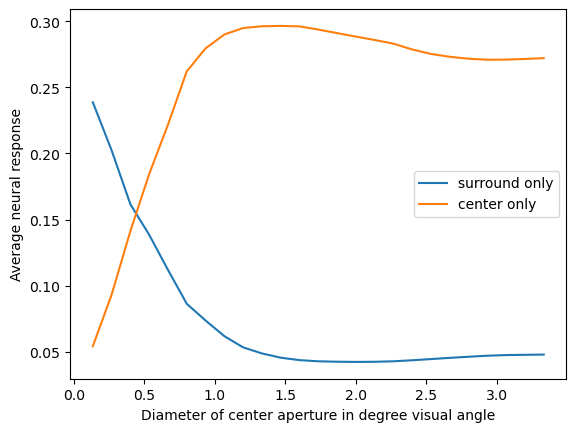

In [9]:
surround = np.average(all_kept_surround, axis = 0)
center = np.average(get_optimal_freq(all_kept_center), axis = 0)
plt.figure()
plt.plot(np.arange(1,26)*2/15, surround, label='surround only')
plt.plot(np.arange(1,26)*2/15, center, label='center only')
plt.xlabel('Diameter of center aperture in degree visual angle')
plt.ylabel('Average neural response')
plt.legend()
plt.savefig('surround_supression.png')

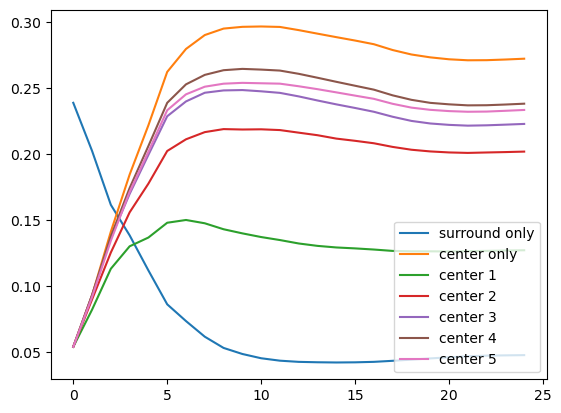

In [12]:
surround = np.average(all_kept_surround, axis = 0)
plt.figure()
plt.plot(surround, label='surround only')
plt.plot(np.average(get_optimal_freq(all_kept_center), axis = 0), label='center only')
plt.plot(np.average(all_kept_center[:,0,:], axis = 0), label='center 1')
plt.plot(np.average(all_kept_center[:,1,:], axis = 0), label='center 2')
plt.plot(np.average(all_kept_center[:,2,:], axis = 0), label='center 3')
plt.plot(np.average(all_kept_center[:,3,:], axis = 0), label='center 4')
plt.plot(np.average(all_kept_center[:,4,:], axis = 0), label='center 5')
plt.legend()

In [12]:
def translate_degree(x):
    return x*2/15

def find_minmax_idx(center_rsp):
    all_diff = []
    for neuron in range(center_rsp.shape[0]):
        curve = center_rsp[neuron]
        max_point = np.argmax(curve)
        low_point_beyond = np.argmin(curve[max_point:])
        low_point = low_point_beyond + max_point
        #low_point = 24
        #diff = (low_point- max_point)/low_point
        diff = low_point/max_point
        all_diff.append(diff)
    return all_diff

def find_minmax_value(center_rsp):
    all_diff = []
    for neuron in range(center_rsp.shape[0]):
        curve = center_rsp[neuron]
        max_point = np.argmax(curve)
        low_point_beyond = np.argmin(curve[max_point:])
        low_point = low_point_beyond + max_point
        all_diff.append((curve[max_point]-curve[low_point])/curve[max_point])
        #all_diff.append(curve[low_point]/curve[max_point])
    return all_diff

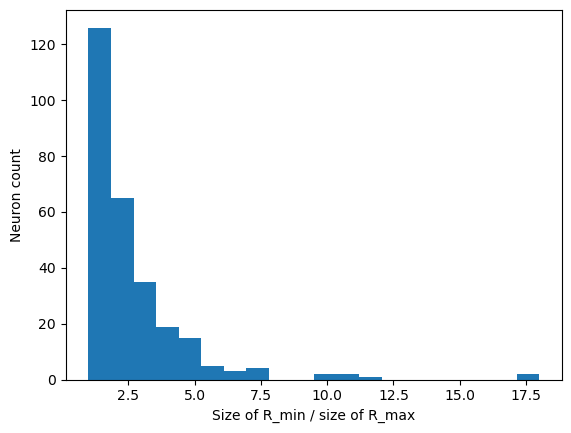

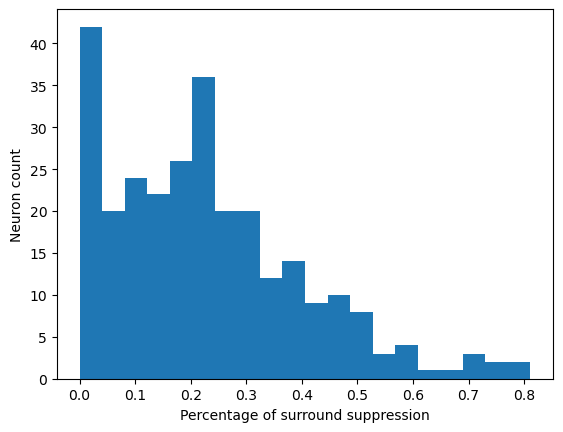

In [17]:
result = find_minmax_idx(get_optimal_freq(all_kept_center))
plt.figure()

plt.hist(result, bins = 20)
plt.ylabel('Neuron count')
plt.xlabel('Size of R_min / size of R_max')
plt.savefig('surround_hist_1')

result2 = find_minmax_value(get_optimal_freq(all_kept_center))
plt.figure()
plt.ylabel('Neuron count')
plt.xlabel('Percentage of surround suppression')
plt.hist(result2, bins=20)
plt.savefig('surround_hist_2')

In [6]:
site = 'm2s1'
val_y = np.load('../data/Processed_Tang_data/all_sites_data_prepared/New_response_data/valRsp_' + site + '.npy')
channels = 256
num_layers = 9
input_size = 50
output_size = val_y.shape[1]
first_k = 9
later_k = 3
pool_size = 2
factorized = True

num_maps = 1

net = BethgeModel(channels=channels, num_layers=num_layers, input_size=input_size,
                  output_size=output_size, first_k=first_k, later_k=later_k,
                  input_channels=1, pool_size=pool_size, factorized=True,
                  num_maps=num_maps).cuda()

net.load_state_dict(torch.load('../saved_models/new_learned_models/' + site + '_9_model_version_0'))
net.eval()
response_center = get_diff_freq_response(net)


  0%|          | 0/299 [00:30<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
make_dir_try("D:/school/research/CNN_Tang_project/Graphs/surround_supression/center_only_m2s1_0/")
for i, s in enumerate(response_center):
    plt.figure()
    plt.plot(s)
    plt.savefig(f"D:/school/research/CNN_Tang_project/Graphs/surround_supression/center_only_m2s1_0/{i}.png")

In [ ]:
make_dir_try("D:/school/research/CNN_Tang_project/Graphs/surround_supression/center_only_m2s1_freq_gray_phase/")
for i, rsps in enumerate(response_center):
    plt.figure()
    for j, rspf in enumerate(rsps):
        plt.plot(range(2,50,2), rspf, label=str(range(4,25,2)[j]), color="black", alpha = (j+1)*1/15)
    plt.legend()
    plt.savefig(f"D:/school/research/CNN_Tang_project/Graphs/surround_supression/center_only_m2s1_freq_gray_phase/{i}.png")

In [12]:
all_neuron_rsp = []
for i, orientation in (enumerate(tqdm(best_orientation))) :
    all_freq_rsp = []
    for contrast in [0, 1, 0.25, 0.5, 1]:
        all_rsp = []
        stimuli = generate_stimuli(15, orientation, (25,25), 0.8, 50, range(1,25,1), np.arange(0,1,0.3))
        for s_radi in stimuli:
            cur_rsp = []
            for s in s_radi:
                s = alter_contrast(s, contrast)
                s = torch.FloatTensor(s).to(device)
                s = torch.reshape(s, (1,1,50,50))
                rsp = net(s)
                cur_rsp.append(rsp.detach().cpu().numpy())
            cur_rsp = np.array(cur_rsp)
            all_rsp.append(np.max(cur_rsp, axis=0))
        all_rsp = np.stack(all_rsp)[:,0,i]
        all_freq_rsp.append(all_rsp)
    all_freq_rsp = np.stack(all_freq_rsp)
    all_neuron_rsp.append(all_freq_rsp)
all_neuron_rsp = np.stack(all_neuron_rsp)

100%|██████████| 324/324 [07:58<00:00,  1.48s/it]


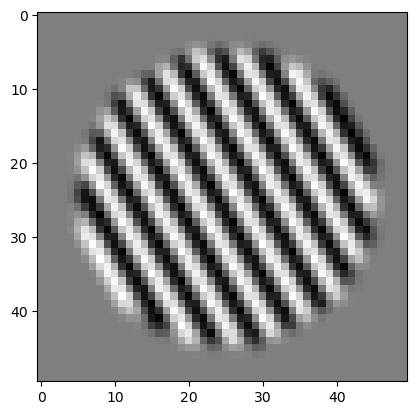

In [6]:

all_rsp = []
stimuli = generate_stimuli(20, 30, (25,25), 0.8, 50, [20],[0], gray=0.5)

#Image.fromarray(np.uint8(np.reshape(stimuli, (50,50))*255))
plt.imshow(np.reshape(stimuli, (50,50)), cmap='gray')

#Image.fromarray(np.uint8(np.reshape(alter_contrast(stimuli, 1.5), (50,50))*255))
# plt.figure()
# plt.imshow(np.reshape(stimuli, (50,50)), cmap='gray')
#
# new_sti = alter_contrast(stimuli, 0.1)
# plt.figure()
# plt.imshow(np.reshape(new_sti, (50,50)), cmap='gray')
# f/2/50 *15

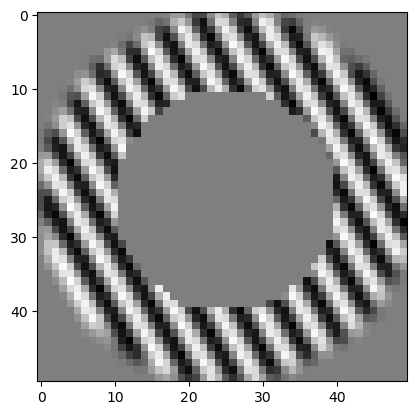

In [3]:

stimuli = generate_center_black_grating(20, 30, (25,25), 0.8, 50, 25,0, [15], gray=0.5)

plt.imshow(np.reshape(stimuli, (50,50)), cmap='gray')
#Image.fromarray(np.uint8(np.reshape(stimuli, (50,50))*255))


In [4]:
print(all_neuron_rsp.shape)
for i, rsps in enumerate(all_neuron_rsp):
    plt.figure()
    for j, rspf in enumerate(rsps):
        plt.plot(range(2,50,2), rspf, label=str(range(4,25,2)[j]), color="black", alpha = (j+1)*1/15)
    plt.legend()
    plt.savefig('surround_suppression_m3s1_35_contrast/'+ str(i+1))


NameError: name 'all_neuron_rsp' is not defined

In [ ]:
print(all_neuron_rsp.shape)
for i, rsps in enumerate(all_neuron_rsp):
    plt.figure()
    for j, rspf in enumerate(rsps):
        plt.plot(range(2,50,2), rspf, label=str([0, 1, 0.25, 0.5, 1][j]))
    plt.legend()
    plt.savefig('surround_suppression_m3s1_35_contrast/'+ str(i+1))

In [ ]:
all_rsp = []
for freq in range(4,20,2):
    stimuli = generate_stimuli(freq, 30, (25,25), 0.8, 50, [15])
    plt.figure()
    plt.imshow(np.reshape(stimuli, (50,50)), cmap="gray")

In [ ]:
all_rsp = []
for freq in range(4,30,2):
    stimuli = generate_stimuli(freq, 30, (25,25), 0.8, 50, [15])
    plt.figure()
    plt.imshow(np.reshape(stimuli, (50,50)), cmap="gray")